In [1]:
import numpy as np
import seaborn as sns
import multiprocessing as mp
import matplotlib.pyplot as plt

from data import C3RData, interpolate
from scipy.integrate import solve_ivp

from tqdm import trange
from deap import base, creator, tools, cma

In [2]:
# better graphs
sns.set()

In [3]:
def ode(t, u, p_est, p_fix, t_range, D_t, U_t):
    # states
    G_p, G_t, I_l, I_p, I_1, I_d, Q_sto1, Q_sto2, Q_gut, X, I_sc1, I_sc2 = u

    # parameters
    k_p2, k_1, k_2, k_p1, k_i, k_e1, k_max, k_min, k_abs, k_p3, k_gri = p_est
    F_cns, k_e2, f, BW, V_m0, V_mx, K_m0, K_mx, m_2, m_1, m_6, k_a1, m_4, k_a2, V_I, a, b, c, d, p_2U, I_b, k_d = p_fix

    # meal intake
    D = D_t[np.abs(t_range - t).argmin()]

    # insulin infusion rate
    U = U_t[np.abs(t_range - t).argmin()]

    dG_p = k_p1 - F_cns - (k_1 * G_p) + (k_2 * G_t) - (k_p2 * G_p) - (k_p3 * I_d) + (k_e1 * (k_e2 - G_p)) + ((f * k_abs * Q_gut)/BW)
    dG_t = (k_1 * G_p) - (k_2 * G_t) - ((G_t * (V_m0 + (V_mx * X))) / (K_m0 + G_t + (K_mx * X)))
    dI_l = (m_2 * I_p) - I_l * (m_1 - ((m_1 * m_6) / (m_6 - 1)))
    dI_p = (k_a1 * I_sc1) - (I_p * (m_2 + m_4)) + (k_a2 * I_sc2) + (m_1 * I_l)
    dI_1 = -k_i * (I_1 - (I_p / V_I))
    dI_d = k_i * (I_1 - I_d)
    dQ_sto1 = (-k_gri * Q_sto1) + D
    dQ_sto2 = (k_gri * Q_sto1) - Q_sto2 * (k_min + ((k_max / 2) - (k_min / 2)) * (np.tanh(a * (Q_sto1 + Q_sto2 - (b * D))) - np.tanh(c * (Q_sto1 + Q_sto2 - (d * D))) + 2))
    dQ_gut = Q_sto2 * (k_min + ((k_max / 2) - (k_min / 2)) * (np.tanh(a * (Q_sto1 + Q_sto2 - (b * D))) - np.tanh(c * (Q_sto1 + Q_sto2 - (d * D))) + 2)) - (k_abs * Q_gut)
    dX = -p_2U * (I_b - (I_p / V_I)) - (p_2U * X)
    dI_sc1 = U - (I_sc1 * (k_a1 + k_d))
    dI_sc2 = (k_d * I_sc1) - (k_a2 * I_sc2)

    return [dG_p, dG_t, dI_l, dI_p, dI_1, dI_d, dQ_sto1, dQ_sto2, dQ_gut, dX, dI_sc1, dI_sc2]

In [4]:
# inputs
t_span = (0, 100)
t_range = np.linspace(*t_span, 100)

D_t = np.zeros_like(t_range)
U_t = 0.1 * np.ones_like(t_range)

D_t[np.abs(t_range - 20).argmin()] = 50
D_t[np.abs(t_range - 50).argmin()] = 80
D_t[np.abs(t_range - 60).argmin()] = 40

U_t[np.abs(t_range - 20).argmin()] = 4
U_t[np.abs(t_range - 50).argmin()] = 8
U_t[np.abs(t_range - 60).argmin()] = 3

In [5]:
# fixed parameters
F_cns = 1
k_e2 = 339
f = 0.90
BW = 60
V_m0 = 2.50
V_mx = 0.047
K_m0 = 225.59
K_mx = 0.0 # ?
m_2 = 0.484
m_1 = 0.190
m_6 = 0.6471
k_a1 = 0.0018
m_4 = 0.194
k_a2 = 0.0182
V_I = 0.05
a = 0.000013
b = 0.82
c = 0.00236
d = 0.01
p_2U = 0.0331
I_b = 25.49
k_d = 0.0164
p_fix = [F_cns, k_e2, f, BW, V_m0, V_mx, K_m0, K_mx, m_2, m_1, m_6, k_a1, m_4, k_a2, V_I, a, b, c, d, p_2U, I_b, k_d]

In [6]:
# parameters to estimate
# k_p2 = 0.0021
# k_1 = 0.065
# k_2 = 0.079
# k_p1 = 2.70
# k_i = 0.0079
# k_e1 = 0.0005
# k_max = 0.0558
# k_min = 0.0080
# k_abs = 0.057
# k_p3 = 0.009
# k_gri = 0.0558
# p_est = [k_p2, k_1, k_2, k_p1, k_i, k_e1, k_max, k_min, k_abs, k_p3, k_gri]

# initial conditions
# G_p_0 = 100.0
# G_t_0 = 20.0
# I_l_0 = 1.0
# I_p_0 = 1.0
I_1_0 = 25.49 # ?
I_d_0 = 25.49 # ?
# Q_sto1_0 = 100.0
# Q_sto2_0 = 100.0
# Q_gut_0 = 100.0
X_0 = 150 # ?
# I_sc1_0 = 500.0
# I_sc2_0 = 200.0

# u0 = [G_p_0, G_t_0, I_l_0, I_p_0, I_1_0, I_d_0, Q_sto1_0, Q_sto2_0, Q_gut_0, X_0, I_sc1_0, I_sc2_0]

In [7]:
# load dataset
c3r = C3RData(data_dir="data")

# get data for a certain case
deident_id = 2
from_dt = f"2014-05-05 00:00:00"
to_dt = f"2014-05-08 00:00:00"

cgm_data, meal_data, insulin_data = c3r.get_case(deident_id, from_dt, to_dt)
t, cgm, meal, insulin = interpolate(cgm_data, meal_data, insulin_data)

t -= t[0]

In [8]:
def objective(p, t, cgm, meal, insulin, p_fix):
    p_u0 = p[:9]
    p_est = p[9:]

    t_span = (t[0], t[-1])
    u0 = [p_u0[0], p_u0[1], p_u0[2], p_u0[3], I_1_0, I_d_0, p_u0[4], p_u0[5], p_u0[6], X_0, p_u0[7], p_u0[8]]

    # solve ODE
    sol = solve_ivp(lambda t, y: ode(t, y, p_est, p_fix, t, meal, insulin), t_span, u0, t_eval=t, method="BDF")

    # calculate MSE
    loss = np.sum((sol.y[9, :] - cgm) ** 2)

    return loss


def simulate(p, t, cgm, meal, insulin, p_fix):
    p_u0 = p[:9]
    p_est = p[9:]

    t_span = (t[0], t[-1])
    u0 = [p_u0[0], p_u0[1], p_u0[2], p_u0[3], I_1_0, I_d_0, p_u0[4], p_u0[5], p_u0[6], X_0, p_u0[7], p_u0[8]]

    # solve ODE
    sol = solve_ivp(lambda t, y: ode(t, y, p_est, p_fix, t, meal, insulin), t_span, u0, t_eval=t, method="BDF")

    return sol

In [9]:
p_min = 0.01
p_max = 500.0
p_len = 9 + 11
p_range = np.vstack((p_min * np.ones(p_len), p_max * np.ones(p_len))).T

def constrain_parameters(p):
    return ((np.tanh(p) + 1) / 2) * (p_range[:, 1] - p_range[:, 0]) + p_range[:, 0]

In [10]:
# evolutionary algorithm parameters
NGEN = 100
SIGMA = 0.5
LAMBDA = 50

# target function
def evaluate(p):
    try:
        return [objective(p, t, cgm, meal, insulin, p_fix)]
    except:
        return [1e10]

# evolutionary algorithm setup
creator.create("FitnessMin", base.Fitness, weights=[-1.0])
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("evaluate", evaluate)

# enable multiprocessing
pool = mp.Pool()
toolbox.register("map", pool.map)

# inital parameter guess
p_guess = p_range.mean(1)

# CMA-ES
strategy = cma.Strategy(centroid=p_guess, sigma=SIGMA, lambda_=LAMBDA)
toolbox.register("generate", strategy.generate, creator.Individual)
toolbox.register("update", strategy.update)

# track best individuals
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda i: i.fitness.values)
stats.register("avg_loss", np.mean)
stats.register("min_loss", np.min)
stats.register("max_loss", np.max)

# train loop
def train(toolbox, ngen, stats, halloffame):
    for _ in trange(ngen, unit="generation"):
        # generate a new population
        population = toolbox.generate()

        # evaluate the individuals
        fitnesses = toolbox.map(toolbox.evaluate, population)
        for ind, fit in zip(population, fitnesses):
            ind.fitness.values = fit

        if halloffame is not None:
            halloffame.update(population)

        # update the strategy with the evaluated individuals
        toolbox.update(population)

        record = stats.compile(population) if stats is not None else {}

In [11]:
train(toolbox, NGEN, stats, hof)

 18%|█▊        | 18/100 [00:39<03:01,  2.22s/generation]


/tmp/ipykernel_32087/701646353.py:15: RuntimeWarning: overflow encountered in double_scalars
  dG_p = k_p1 - F_cns - (k_1 * G_p) + (k_2 * G_t) - (k_p2 * G_p) - (k_p3 * I_d) + (k_e1 * (k_e2 - G_p)) + ((f * k_abs * Q_gut)/BW)
/tmp/ipykernel_32087/701646353.py:16: RuntimeWarning: overflow encountered in double_scalars
  dG_t = (k_1 * G_p) - (k_2 * G_t) - ((G_t * (V_m0 + (V_mx * X))) / (K_m0 + G_t + (K_mx * X)))
/home2/vishva.saravanan/miniconda3/envs/v/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:329: RuntimeWarning: invalid value encountered in subtract
  diff = f_new - f[:, None]
/tmp/ipykernel_32087/701646353.py:21: RuntimeWarning: overflow encountered in double_scalars
  dQ_sto1 = (-k_gri * Q_sto1) + D
/tmp/ipykernel_32087/701646353.py:22: RuntimeWarning: overflow encountered in double_scalars
  dQ_sto2 = (k_gri * Q_sto1) - Q_sto2 * (k_min + ((k_max / 2) - (k_min / 2)) * (np.tanh(a * (Q_sto1 + Q_sto2 - (b * D))) - np.tanh(c * (Q_sto1 + Q_sto2 - (d * D))) + 2))
/tmp/ipyk

KeyboardInterrupt: 

In [ ]:
sol = simulate(constrain_parameters(hof.items[0]), t, cgm, meal, insulin, p_fix)

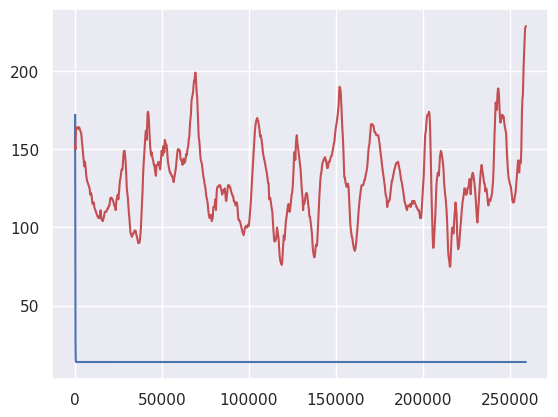

In [ ]:
plt.plot(sol.t, sol.y[9, :])
plt.plot(t, cgm, "r")
plt.show()